# Desafio 2:
## integrantes: Dario, Federico, Mauro, Qiyin

## Tabla de contenidos
1. [Introducción](#id1)
2. [Organización de los datos](#id2)
3. [Explorando los datos](#id3)
4. [Construcción de modelos CNN](#id4)
5. [Transfer Learning](#id5)
6. [Feature Extraction](#id6)
7. [Comparamos los modelos](#id7)
8. [Test del modelo](#id8)

<a id="id1"></a>
# Introducción

Los datos provienen del desafío de Kaggle "Desafíos en el aprendizaje de representación: desafío de reconocimiento de expresiones faciales":

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

Los datos consisten en imágenes de caras en escala de grises de 48x48 píxeles. Las caras se han registrado automáticamente para que la cara esté más o menos centrada y ocupe aproximadamente la misma cantidad de espacio en cada imagen. Cada imagen corresponde a una expresión facial en una de las siete categorías (0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral). El conjunto de datos contiene aproximadamente 36K imágenes.

<a id="id2"></a>
## Organización de los datos

In [ ]:
# Colab library to upload files to notebook

'''descomentar para correr en COLAAB
#from google.colab import files

# Install Kaggle library
!pip install -q kaggle'''

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Descomentar para correr en COLAB
#Subir el Apikey de Colab
'''#uploaded = files.upload()'''

In [ ]:
#Descomentar esto para correrlo en COLAB
'''
!mkdir .kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
'''

In [ ]:
!kaggle datasets download -d --force jonathanoheix/face-expression-recognition-dataset

In [ ]:
'''Descomentar para correr en COLAB
!unzip /content/face-expression-recognition-dataset.zip
'''
!tar -xf face-expression-recognition-dataset.zip

<a id="id3"></a>
## Explorando los datos

Obtenemos los nombres de las carpetas

In [12]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# Tamaño de la imagen: 48*48 pixels
pic_size = 48

base_path = "images/"
base_path_train = base_path + "train/"
expression_list = os.listdir(base_path_train) 
print(expression_list)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Visualizamos algunas imagenes por categoria

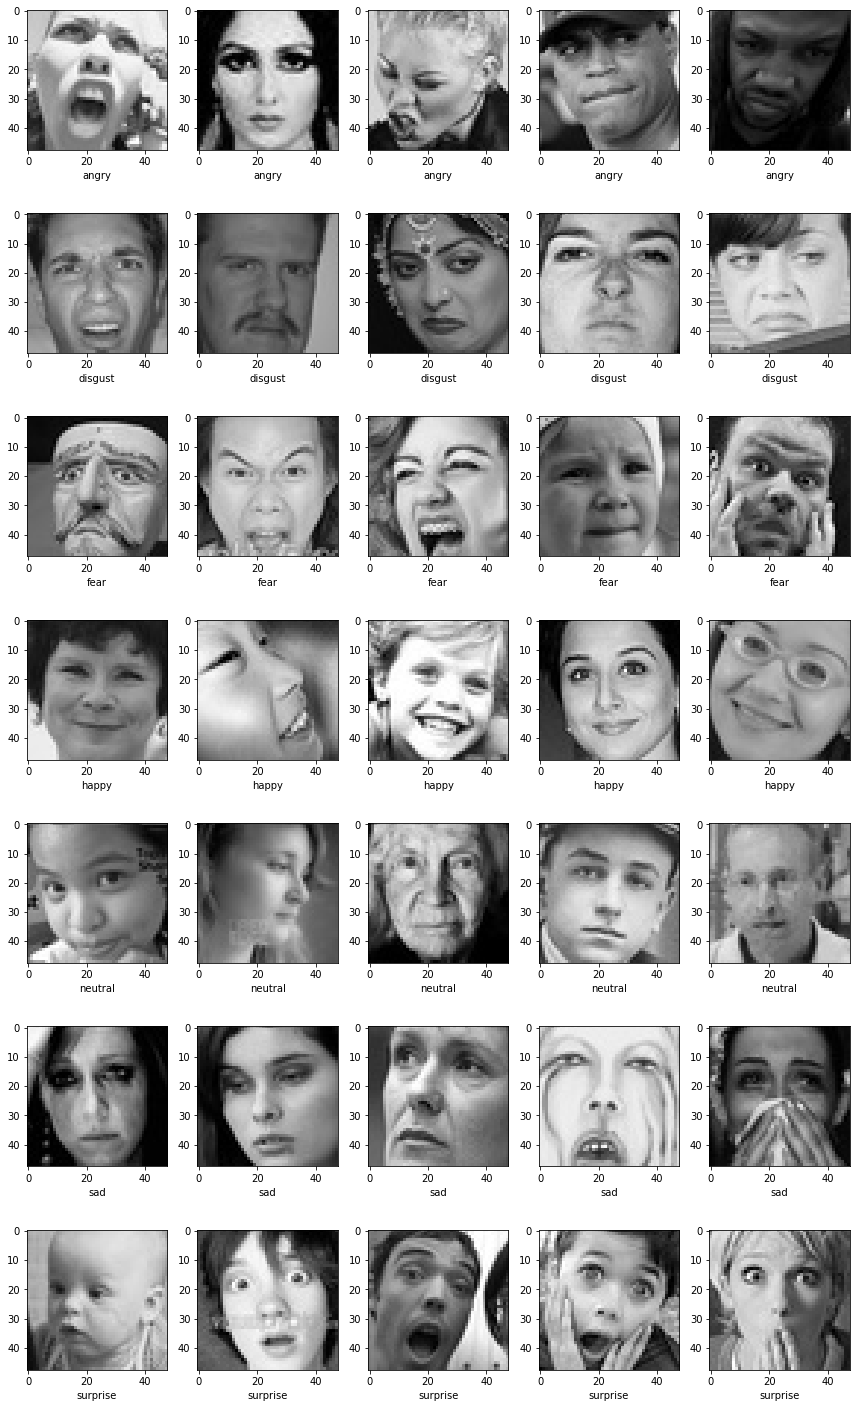

In [13]:
plt.figure(0, figsize=(12,20))
cpt = 0


from random import randrange #Para poder elegir un elementos aleatorios dentro de la carpeta
for expression in expression_list:
    for i in range(1,6):
        q_items_in_folder = len(os.listdir(base_path_train + expression))
        cpt = cpt + 1
        plt.subplot(7,5,cpt, xlabel=expression)        
        img = load_img(base_path_train + expression + "/" +os.listdir(base_path_train + expression)[randrange(q_items_in_folder)], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

Contamos cuantas imagenes hay por categoria

In [14]:
total = 0
for expression in expression_list:
    print(str(len(os.listdir(base_path_train + expression))) + " " + expression)
    total += len(os.listdir(base_path_train + expression))
print("Un total de "+ str(total)+ " imágenes, en "+str(len(expression_list)) +" Categorías")

3993 angry
436 disgust
4103 fear
7164 happy
4982 neutral
4938 sad
3205 surprise
Un total de 28821 imágenes, en 7 Categorías


<a id="id4"></a>
## Construcción de modelos CNN

In [15]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path_train,
                                                   target_size= (pic_size, pic_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                   target_size= (pic_size, pic_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_train_rgb  = ImageDataGenerator()
datagen_validation_rgb = ImageDataGenerator()
rgb_train_generator = datagen_train_rgb.flow_from_directory(base_path + "validation",
                                                   target_size= (pic_size, pic_size),
                                                   color_mode = "rgb",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

rgb_validation_generator = datagen_validation_rgb.flow_from_directory(base_path + "validation",
                                                   target_size= (pic_size, pic_size),
                                                   color_mode = "rgb",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


'\ntrain_generator = tf.keras.preprocessing.image_dataset_from_directory(base_path_train,\n                                                   labels="infered")\n\nvalidation_generator = datagen_validation.image_dataset_from_directory(base_path_train,\n                                                   labels="infered")'

In [100]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model1 = Sequential()
model1.name = "CNN_64x3_128x5_512x3_512x3_FCNN_255_512"
# 1 - Convolution
model1.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# 2nd Convolution layer
model1.add(Conv2D(128,(5,5), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# 3rd Convolution layer
model1.add(Conv2D(512,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# 4th Convolution layer
model1.add(Conv2D(512,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# Flattening
model1.add(Flatten())

# Fully connected layer 1st layer
model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

# Fully connected layer 2nd layer
model1.add(Dense(512))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print (model1.summary())

Model: "CNN_64x3_128x5_512x3_512x3_FCNN_255_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_31 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_31 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_32 (Bat

In [101]:
#El modelito que vimos en clase
model2 = Sequential()
model2.name = "lenet"
model2.add(Conv2D(filters=6, kernel_size=(5,5),padding="same", activation="tanh", input_shape=(48,48,1)))
model2.add(AveragePooling2D((2,2)))
model2.add(Conv2D(filters=16,kernel_size=(5,5),activation="tanh"))
model2.add(AveragePooling2D((2,2)))
model2.add(Flatten())
model2.add(Dense(120,activation = "tanh"))
model2.add(Dense(84, activation ="tanh"))
model2.add(Dense(nb_classes, activation ="softmax"))
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 48, 48, 6)         156       
_________________________________________________________________
average_pooling2d_7 (Average (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 20, 20, 16)        2416      
_________________________________________________________________
average_pooling2d_8 (Average (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 120)               192120    
_________________________________________________________________
dense_51 (Dense)             (None, 84)                10164 

In [102]:
#El modelito que vimos en clase
model3 = Sequential()
model3.name = "lenet_updated_relu_maxPooling_dropout"
model3.add(Conv2D(filters=6, kernel_size=(5,5),padding="same", activation="relu", input_shape=(48,48,1)))
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(.1))
model3.add(Conv2D(filters=16,kernel_size=(5,5),activation="relu"))
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(.1))
model3.add(Flatten())
model3.add(Dense(120,activation = "relu"))
model3.add(Dropout(.1))
model3.add(Dense(84,activation = "relu"))
model3.add(Dropout(.1))
model3.add(Dense(nb_classes, activation = "softmax"))
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "lenet_updated_relu_maxPooling_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 24, 24, 6)         0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 20, 20, 16)        2416      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_17 (Flatten)         

In [76]:
#Transfer Learning de Mobilenet
import tensorflow as tf
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(48,48,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
capa_clasificacion = tf.keras.layers.Dense(nb_classes, activation="softmax")
capa_densa = tf.keras.layers.Dense(512, activation="softmax")
model4 = tf.keras.Sequential([base_model,global_average_pooling_layer,capa_densa,capa_clasificacion])
model4._name = "Transfer Learning"
#model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 2,917,447
Trainable params: 659,463
Non-trainable params: 2,257,984
_________________________________________________________________


In [103]:
#El modelito que vimos en clase
model5 = Sequential()
model5.name = "lenet_updated_more_convolutions"
model5.add(Conv2D(filters=6, kernel_size=(5,5),padding="same", activation="relu", input_shape=(48,48,1)))
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(.1))
model5.add(Conv2D(filters=16,kernel_size=(5,5),activation="relu"))
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(.1))
model5.add(Conv2D(filters=128, kernel_size=(5,5),padding="same", activation="relu", input_shape=(48,48,1)))
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(.1))
model5.add(Flatten())
model5.add(Dense(120,activation = "relu"))
model5.add(Dropout(.1))
model5.add(Dense(84,activation = "relu"))
model5.add(Dropout(.1))
model5.add(Dense(nb_classes, activation = "softmax"))
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "lenet_updated_more_convolutions"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 24, 24, 6)         0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 20, 20, 16)        2416      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None,

In [90]:
#Preparo todo para el entrenamiento de los modelos
# number of epochs to train the NN
epochs = 60
#Guardo todos los modelos en un iterable
modelos = [model2, model3, model5, model]
for model in modelos:
    print (model.name)

training_history = []
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping (patience = 6)
callbacks_list = [checkpoint,early_stopping]

#%%time

lenet
lenet_updated_relu_maxPooling_dropout
lenet_updated_more_convolutions
CNN_64x3_128x5_512x3_512x3_FCNN_255_512


In [102]:
#modelos = [model2]
for model in modelos:
    checkpoint = ModelCheckpoint( model.name+".h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping (patience = 10)
    callbacks_list = [checkpoint,early_stopping]
    history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )
    training_history.append(history)
    #Guardo el modelo
    model_json = model.to_json()
    with open(model.name+".json", "w") as json_file:
        json_file.write(model_json)
    #guardo la historia
    np.save(model.name+'.npy',history.history)

Epoch 1/60
225/225 [==============================] - 17s 73ms/step - loss: 1.2782 - accuracy: 0.5195 - val_loss: 1.4125 - val_accuracy: 0.4602

Epoch 00001: val_accuracy improved from -inf to 0.46023, saving model to lenet.h5
Epoch 2/60
225/225 [==============================] - 17s 74ms/step - loss: 1.2656 - accuracy: 0.5257 - val_loss: 1.2940 - val_accuracy: 0.4625

Epoch 00002: val_accuracy improved from 0.46023 to 0.46253, saving model to lenet.h5
Epoch 3/60
225/225 [==============================] - 16s 73ms/step - loss: 1.2507 - accuracy: 0.5313 - val_loss: 1.4384 - val_accuracy: 0.4743

Epoch 00003: val_accuracy improved from 0.46253 to 0.47434, saving model to lenet.h5
Epoch 4/60
225/225 [==============================] - 17s 74ms/step - loss: 1.2360 - accuracy: 0.5370 - val_loss: 1.2258 - val_accuracy: 0.4748

Epoch 00004: val_accuracy improved from 0.47434 to 0.47478, saving model to lenet.h5
Epoch 5/60
225/225 [==============================] - 16s 72ms/step - loss: 1.2225 

In [108]:
# plot the evolution of Loss and Acuracy on the train and validation sets
histories = []
for model in modelos:
    histories.append({"name":model.name,"history": np.load(model.name+'.npy',allow_pickle='TRUE').item()})

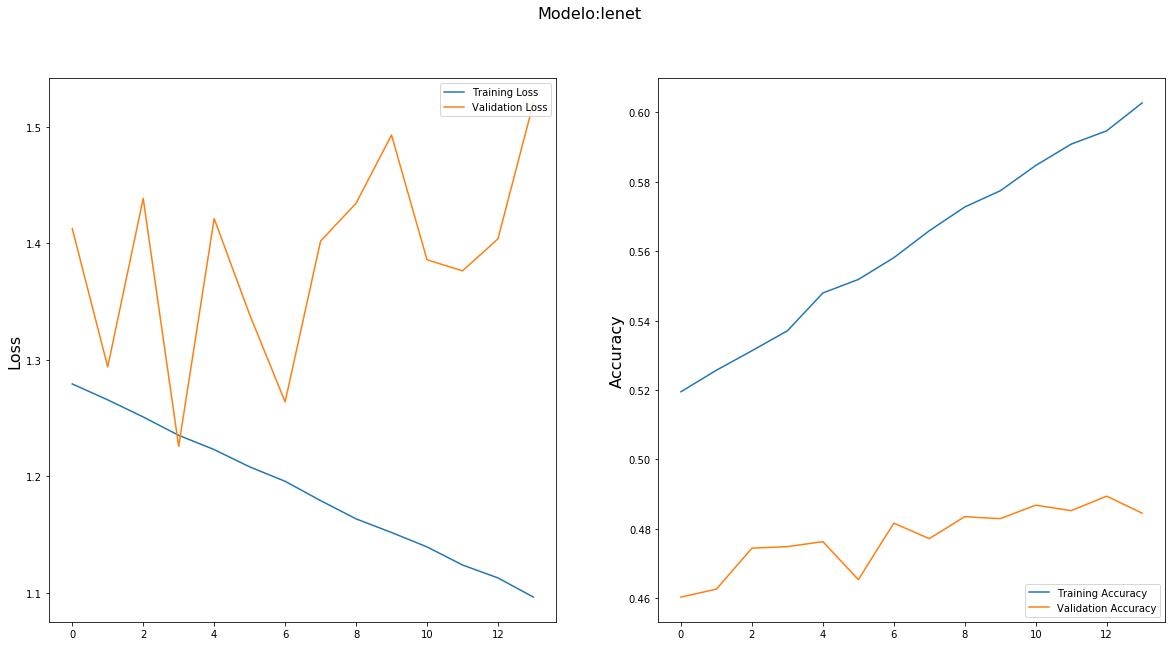

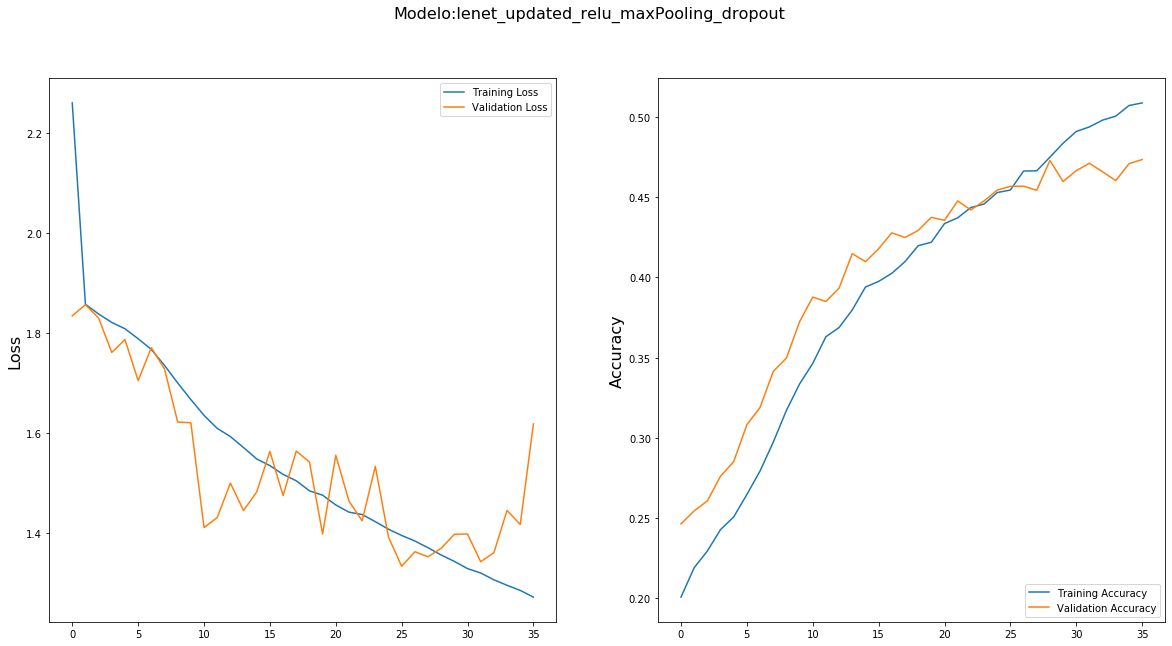

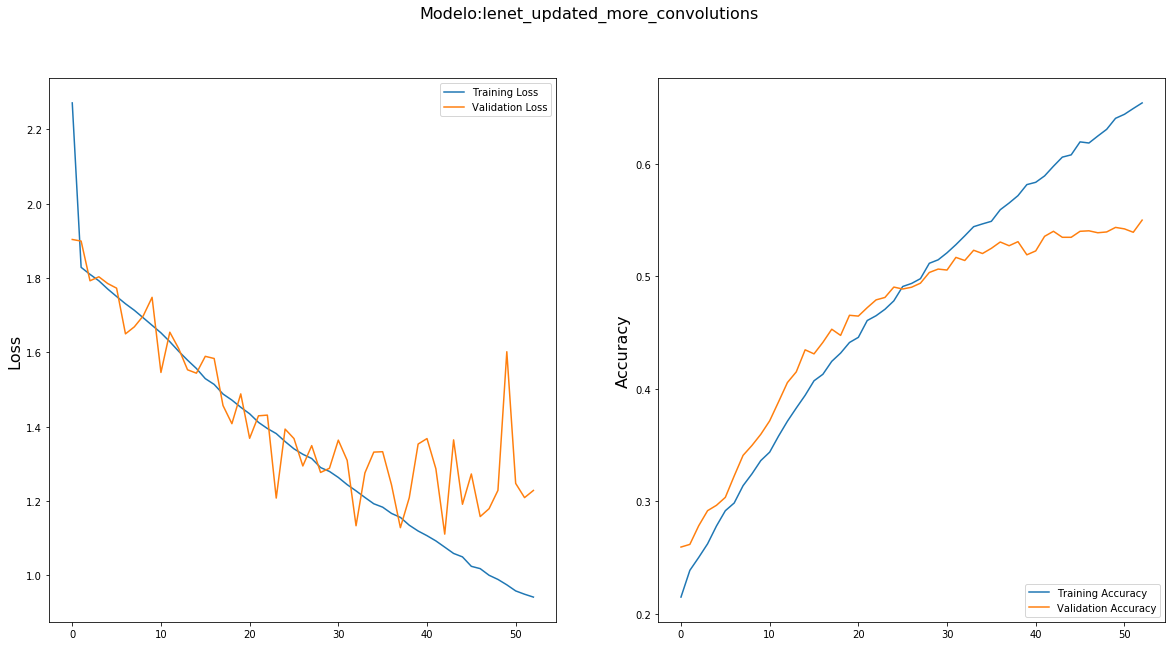

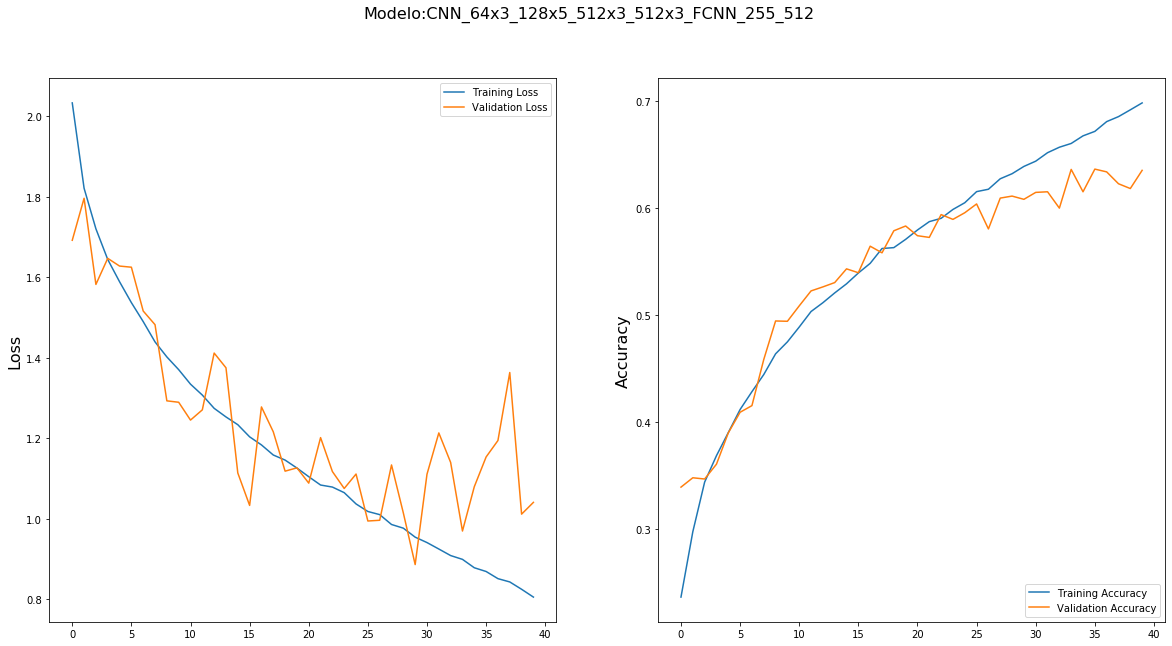

In [109]:
    
import matplotlib.pyplot as plt
for model in histories:
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Modelo:'+model["name"], fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(model["history"]['loss'], label='Training Loss')
    plt.plot(model["history"]['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(model["history"]['accuracy'], label='Training Accuracy')
    plt.plot(model["history"]['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
#np.save('my_history.npy',history2.history)
#history=np.load('my_history.npy',allow_pickle='TRUE').item()

<a id="id5"></a>
## Transfer Learning

El Transfer Learning es un método de aprendizaje automático en el que un modelo desarrollado para una tarea se reutiliza como punto de partida para un modelo en una segunda tarea.

In [104]:
from keras.models import load_model
from keras import models
from keras import layers
from keras import optimizers

MobileNet =load_model('mobilenet.h5')
MobileNet.name = 'MobileNetSave'
MobileNet.trainable = False
MobileNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
MobileNet.summary()

Model: "MobileNetSave"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)      

In [34]:
batch_size = 128
epochs = 25
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(validation_generator.n / batch_size)

history = MobileNet.fit_generator(generator=rgb_train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=rgb_validation_generator,
                              validation_steps=validation_steps)

Epoch 1/25
226/226 [==============================] - 214s 945ms/step - loss: 1.6003 - accuracy: 0.3823 - val_loss: 2.1152 - val_accuracy: 0.0290
Epoch 2/25
226/226 [==============================] - 211s 932ms/step - loss: 1.5922 - accuracy: 0.3827 - val_loss: 2.1045 - val_accuracy: 0.0290
Epoch 3/25
226/226 [==============================] - 193s 854ms/step - loss: 1.5985 - accuracy: 0.3820 - val_loss: 2.0902 - val_accuracy: 0.0290
Epoch 4/25
226/226 [==============================] - 190s 839ms/step - loss: 1.5924 - accuracy: 0.3827 - val_loss: 2.1251 - val_accuracy: 0.0290
Epoch 5/25
226/226 [==============================] - 192s 848ms/step - loss: 1.5943 - accuracy: 0.3836 - val_loss: 2.0959 - val_accuracy: 0.0290
Epoch 6/25
226/226 [==============================] - 199s 883ms/step - loss: 1.6015 - accuracy: 0.3796 - val_loss: 2.0198 - val_accuracy: 0.0290
Epoch 7/25
226/226 [==============================] - 199s 878ms/step - loss: 1.5978 - accuracy: 0.3835 - val_loss: 1.9673 -

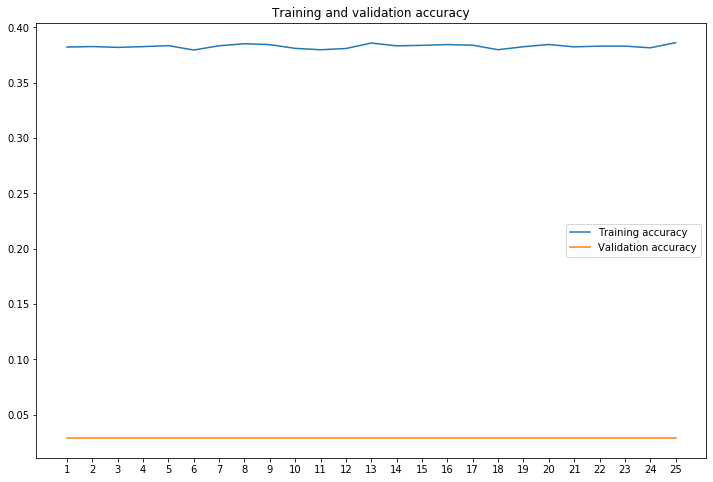

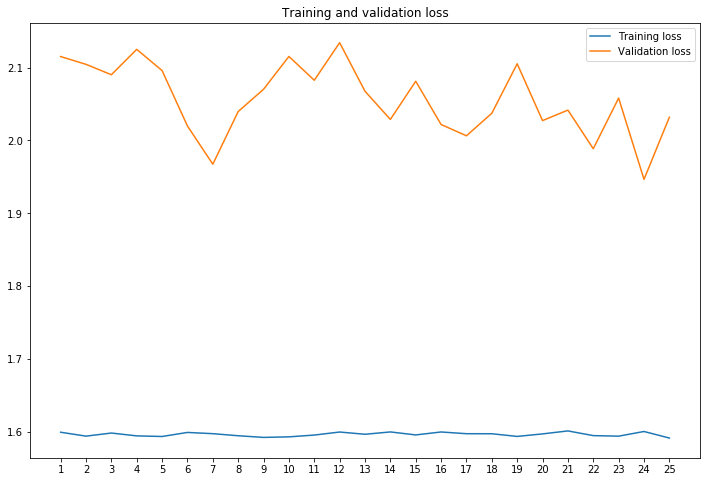

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
np.save('MobileNetSave.npy',history.history)

<a id="id6"></a>
## Feature Extraction

Feature extraction consiste en usar las representaciones aprendidas por una red preentrenada para extraer atributos interesantes de nuevas muestras y luego utilizarlas en un nuevo clasificador

In [105]:
from keras.applications import MobileNet

feature_extraction = MobileNet(input_shape=(48, 48, 3), include_top=False)
feature_extraction.name = "feature_extraction"
feature_extraction.trainable = False
feature_extraction.summary()

Model: "feature_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32) 

In [39]:
base_dir = 'images/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  
    features = np.zeros(shape=(sample_count, 1, 1, 1024))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(48, 48),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extraction.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 28821)
validation_features, validation_labels = extract_features(validation_dir, 7066)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [40]:
train_labels.shape

(28821,)

In [41]:
train_features_reshape = np.reshape(train_features, (28821  , 1 * 1 * 1024))
validation_features_reshape = np.reshape(validation_features, (7066  , 1 * 1 * 1024))

In [42]:
from tensorflow.keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels)
validation_labels_cat = to_categorical(validation_labels)

In [43]:
train_labels_cat.shape

(28821, 7)

In [46]:
feature = models.Sequential()
feature.name = "FeatureSave"
feature.add(layers.Dense(1024, activation='relu', input_dim=1 * 1 * 1024))
feature.add(layers.Dropout(0.5))
feature.add(layers.Dense(7, activation='softmax'))

feature.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = feature.fit(train_features_reshape, train_labels_cat,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features_reshape, validation_labels_cat))

Train on 28821 samples, validate on 7066 samples
Epoch 1/30
28821/28821 [==============================] - 28s 955us/step - loss: 1.8403 - accuracy: 0.2406 - val_loss: 1.7844 - val_accuracy: 0.2625
Epoch 2/30
28821/28821 [==============================] - 26s 886us/step - loss: 1.7860 - accuracy: 0.2622 - val_loss: 1.7676 - val_accuracy: 0.2746
Epoch 3/30
28821/28821 [==============================] - 26s 889us/step - loss: 1.7727 - accuracy: 0.2686 - val_loss: 1.7589 - val_accuracy: 0.2794
Epoch 4/30
28821/28821 [==============================] - 26s 886us/step - loss: 1.7634 - accuracy: 0.2761 - val_loss: 1.7546 - val_accuracy: 0.2809
Epoch 5/30
28821/28821 [==============================] - 27s 932us/step - loss: 1.7569 - accuracy: 0.2789 - val_loss: 1.7507 - val_accuracy: 0.2812
Epoch 6/30
28821/28821 [==============================] - 26s 885us/step - loss: 1.7534 - accuracy: 0.2804 - val_loss: 1.7483 - val_accuracy: 0.2840
Epoch 7/30
28821/28821 [==============================] -

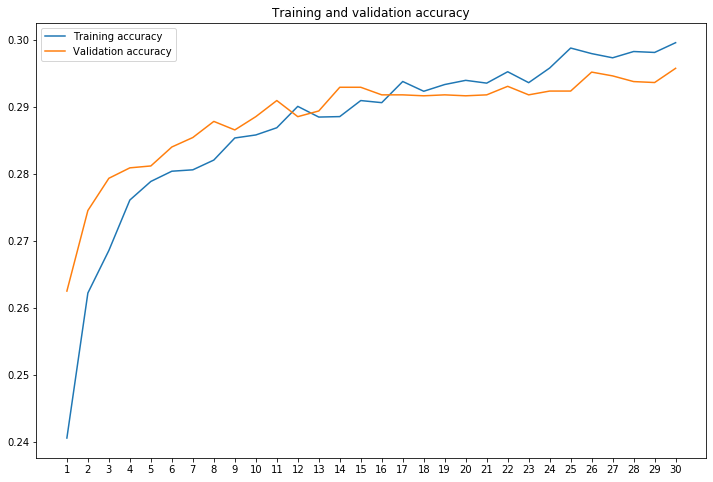

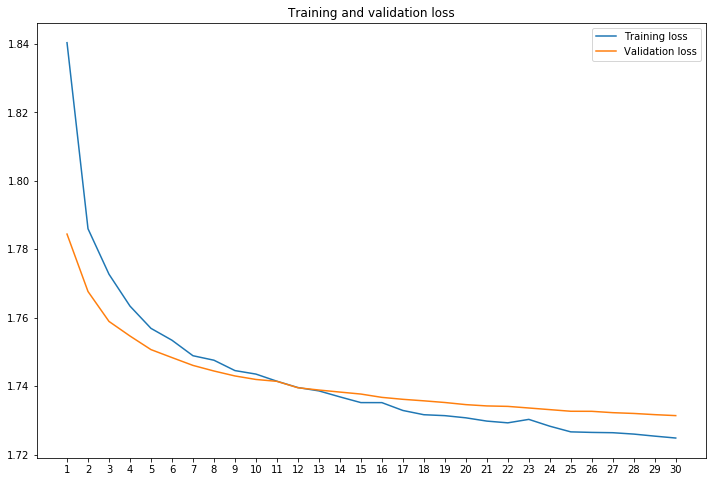

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
np.save('FeatureSave.npy',history.history)

<a id="id7"></a>
## Comparamos los modelos

In [107]:
modelos_am = [model1, model2, model3, model5, feature]
for model in modelos_am:
    print(model.name)
    
historial = []
for model in modelos_am:
    historial.append({"name":model.name,"history": np.load(model.name+'.npy',allow_pickle='TRUE').item()})

CNN_64x3_128x5_512x3_512x3_FCNN_255_512
lenet
lenet_updated_relu_maxPooling_dropout
lenet_updated_more_convolutions
FeatureSave


In [118]:
nombres = []
valores_acc = []
valores_lost = []
valores_valid = []

for model in historial:
    nombres.append(model['name'])
    valores_acc.append(model["history"]['accuracy'][-1])
    valores_lost.append(model["history"]['loss'][-1])
    valores_valid.append(model["history"]['val_accuracy'][-1])

In [119]:
import pandas as pd

df = pd.DataFrame(list(zip(valores_acc, valores_lost,valores_valid)),index = nombres,
               columns =['accuracy', 'loss','val_accuracy']) 

def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]
 
df.style.apply(highlight_max)

,accuracy,loss,val_accuracy
CNN_64x3_128x5_512x3_512x3_FCNN_255_512,0.698524,0.805915,0.635486
lenet,0.602760,1.096557,0.484434
lenet_updated_relu_maxPooling_dropout,0.508800,1.271585,0.473479
lenet_updated_more_convolutions,0.654201,0.941354,0.550014
FeatureSave,0.299608,1.724836,0.295783


**Vemos que el modelo con mejor performance es el CNN_64x3_128x5_512x3_512x3_FCNN_255_512**

<a id="id8"></a>
## Test del Modelo

Utilizamos el modelo de mejor performance

In [110]:
import cv2
classifier =load_model('CNN_64x3_128x5_512x3_512x3_FCNN_255_512.h5')
classifier.summary()

Model: "CNN_64x3_128x5_512x3_512x3_FCNN_255_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_14 (Bat

In [112]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

Codigo que nos permite tomar fotos

In [114]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("fallo")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Salir, cerrando...")
        break
    elif k%256 == 32:
        # presionar la tecla espaciadora
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} Guardado!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.png Guardado!
Salir, cerrando...


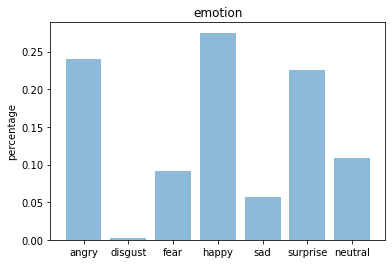

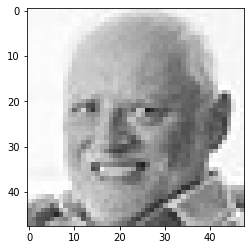

In [117]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

base = "image_test/"
file = base + 'harol.jpeg'
 
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = classifier.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

**Testing en tiempo real**

In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np


face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
classifier =load_model('model25.h5')

class_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
cap = cv2.VideoCapture(0)
while True:
    # Grab a single frame of video
    ret, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
    # rect,face,image = face_detector(frame)


        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

        # make a prediction on the ROI, then lookup the class

            preds = classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()